xt tensor([0.1411, 0.5787, 0.7438, 0.9033, 1.0670, 1.1769, 1.2150, 1.3403, 1.4690,
        1.7010, 1.7062, 1.7121, 1.7643, 1.8257, 2.1352, 2.1645, 2.3619, 2.4417,
        2.4873, 2.5039, 2.5368, 2.5611, 2.9143, 3.0530, 3.0551, 3.0704, 3.3284,
        3.3551, 3.4825, 3.5219, 3.5678, 3.7238, 3.7772, 3.8150, 3.8818, 4.0252,
        4.1767, 4.1918, 4.2537, 4.3349, 4.3559, 4.5192, 4.6005, 4.7117, 4.7666,
        4.8034, 4.8173, 4.8696, 4.8787, 4.8897])
含参汇聚
0


RuntimeError: The size of tensor a (49) must match the size of tensor b (2) at non-singleton dimension 1

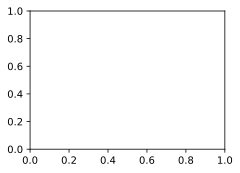

In [35]:
import torch
from torch import nn
from d2l import torch as d2l

# import time

class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # self.w = nn.Parameter(torch.rand((0.1,), requires_grad=True))
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)


        mma = self.attention_weights.unsqueeze(1)
        mmb = values.unsqueeze(-1)
        out = torch.bmm(mma,mmb).reshape(-1)
        print('mma',mma)

        print('self.w',self.w)
        print('self.w',self.w.shape)
        return out
    
        # return torch.bmm(self.attention_weights.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)
    

class class_a():
    def __init__(self):
        self.main()

    def plot_kernel_reg(self,x_test,y_hat,y_truth,x_train, y_train):
        d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
                xlim=[0, 5], ylim=[-1, 5])
        d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

    def f(self,x):
        # return 2 * torch.tanh(x) + x**0.8
        # return 2 * torch.sin(x) + x**(-0.5)
        # return 2 * torch.sin(x) + x**(-1)
        # return 2 * torch.log(x) + x**(-0.5)
        return 2 * torch.sin(x) + x**0.8



    def avg_pooling(self,x_test,y_hat,y_truth,x_train, y_train):
        
        n_test = len(x_test)  # 测试样本数
        print('平均汇聚')
        y_hat = torch.repeat_interleave(y_train.mean(), n_test)
        self.plot_kernel_reg(x_test,y_hat,y_truth,x_train, y_train)
        # time.sleep(1)


    def no_para_pooling(self,x_test,y_hat,y_truth,x_train, y_train):
    
        n_train = self.n_train  # 训练样本数


        print('无参汇聚')
        # X_repeat的形状:(n_test,n_train),
        # 每一行都包含着相同的测试输入（例如：同样的查询）
        X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
        # x_train包含着键。attention_weights的形状：(n_test,n_train),
        # 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
        attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
        # y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
        y_hat = torch.matmul(attention_weights, y_train)
        self.plot_kernel_reg(x_test,y_hat,y_truth,x_train, y_train)
        # self.plot_kernel_reg(y_hat)


        d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                    xlabel='Sorted training inputs',
                    ylabel='Sorted testing inputs')
        


    def para_pooling(self,x_test,y_hat,y_truth,x_train, y_train):
        print('含参汇聚')
        n_train = self.n_train  # 训练样本数
        n_test = len(x_test)  # 测试样本数


        X = torch.ones((2, 1, 4))
        Y = torch.ones((2, 4, 6))
        torch.bmm(X, Y).shape


        weights = torch.ones((2, 10)) * 0.1
        values = torch.arange(20.0).reshape((2, 10))
        torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))



        # X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
        X_tile = x_train.repeat((n_train, 1))
        # Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
        Y_tile = y_train.repeat((n_train, 1))
        # keys的形状:('n_train'，'n_train'-1)
        keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
        # values的形状:('n_train'，'n_train'-1)
        values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

        net = NWKernelRegression()
        loss = nn.MSELoss(reduction='none')
        trainer = torch.optim.SGD(net.parameters(), lr=0.5)
        animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

        train_count = 2**5

        for epoch in range(train_count):
            print(epoch)
            trainer.zero_grad()
            l = loss(net(x_train, keys, values), y_train)

            # print('loss',float(l))
            # print('loss',l)
            # input('wefoewio')
            # loss_tensor = l.sum()
            l.sum().backward()
            # loss_tensor.backward()
            # # loss = float(loss_tensor)
            # losstt = loss_tensor.to('cpu')
            # print('loss',losstt)

            trainer.step()
            print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
            animator.add(epoch + 1, float(l.sum()))


        print('test')

        # keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
        keys = x_train.repeat((n_test, 1))
        # value的形状:(n_test，n_train)
        values = y_train.repeat((n_test, 1))
        out = net(x_test, keys, values).detach()
        y_hat = out.unsqueeze(1)
        # y_hat = net(x_test, keys, values).unsqueeze(1).detach()

        print('keys',keys.shape)
        print('keys',keys)
        print('value',values)
        print('value',values.shape)
        print('out',out)

        # print('y_hat',y_hat)
        print('y_hat',y_hat.shape)

        self.plot_kernel_reg(x_test,y_hat,y_truth,x_train, y_train)

        d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

    def main(self,):

        self.n_train = 50  # 训练样本数
        n_train = self.n_train  # 训练样本数


        x_train, _ = torch.sort(torch.rand(n_train) * 5)   # 排序后的训练样本
        # x_train = torch.rand(n_train) * 5  # 排序后的训练样本


        y_train = self.f(x_train) + torch.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
        # y_train = self.f(x_train) + torch.normal(0.0, 1, (n_train,))  # 训练样本的输出
        # y_train = self.f(x_train)
        x_test = torch.arange(0, 5, 0.1)  # 测试样本
        y_truth = self.f(x_test)  # 测试样本的真实输出
        n_test = len(x_test)  # 测试样本数
        # print(n_test)

        print('xt',x_train)
        y_hat = 0
        self.para_pooling(x_test,y_hat,y_truth,x_train, y_train)


if __name__ == '__main__':
    class_a()